In [1]:
!python --version

Python 3.10.13


In [2]:
!nvidia-smi

Sat Apr  6 20:06:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0              27W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
!lscpu

Architecture:                       x86_64
CPU op-mode(s):                     32-bit, 64-bit
Byte Order:                         Little Endian
Address sizes:                      46 bits physical, 48 bits virtual
CPU(s):                             4
On-line CPU(s) list:                0-3
Thread(s) per core:                 2
Core(s) per socket:                 2
Socket(s):                          1
NUMA node(s):                       1
Vendor ID:                          GenuineIntel
CPU family:                         6
Model:                              85
Model name:                         Intel(R) Xeon(R) CPU @ 2.00GHz
Stepping:                           3
CPU MHz:                            2000.172
BogoMIPS:                           4000.34
Hypervisor vendor:                  KVM
Virtualization type:                full
L1d cache:                          64 KiB
L1i cache:                          64 KiB
L2 cache:                           2 MiB
L3 cache:                  

In [4]:
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, concatenate, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras.layers import SpatialDropout2D
from keras import backend as K
from keras.optimizers import Adam

import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
np.random.seed(101)

2024-04-06 20:06:27.170486: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-06 20:06:27.170589: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-06 20:06:27.308516: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
print('tf version: ', tf.__version__)

tf version:  2.15.0


## Loading the Data

Defining a function to load the data in sorted order

In [6]:
import re

numbers = re.compile(r'(\d+)')

def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [7]:
filelist_trainx = sorted(glob.glob('../input/*/trainx/*.bmp'), key=numericalSort)
X_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainx])

filelist_trainy = sorted(glob.glob('../input/*/trainy/*.bmp'), key=numericalSort)
Y_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainy])

Splitting the dataset into training set and test set to verify our model performance without any bias.

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size = 0.25, random_state = 101)

Let's plot an image to see how the original images look.

In [9]:
plt.figure(figsize=(20,9))

plt.subplot(2,4,1)
plt.imshow(X_train[0])

plt.subplot(2,4,2)
plt.imshow(X_train[3])

plt.subplot(2,4,3)
plt.imshow(X_train[54])

plt.subplot(2,4,4)
plt.imshow(X_train[77])

plt.subplot(2,4,5)
plt.imshow(X_train[100])

plt.subplot(2,4,6)
plt.imshow(X_train[125])

plt.subplot(2,4,7)
plt.imshow(X_train[130])

plt.subplot(2,4,8)
plt.imshow(X_train[149])

plt.show()

Now let's see their corresponding masks.

In [10]:
plt.figure(figsize=(20,9))

plt.subplot(2,4,1)
plt.imshow(Y_train[0], cmap = plt.cm.binary_r)

plt.subplot(2,4,2)
plt.imshow(Y_train[3], cmap = plt.cm.binary_r)

plt.subplot(2,4,3)
plt.imshow(Y_train[54], cmap = plt.cm.binary_r)

plt.subplot(2,4,4)
plt.imshow(Y_train[77], cmap = plt.cm.binary_r)

plt.subplot(2,4,5)
plt.imshow(Y_train[100], cmap = plt.cm.binary_r)

plt.subplot(2,4,6)
plt.imshow(Y_train[125], cmap = plt.cm.binary_r)

plt.subplot(2,4,7)
plt.imshow(Y_train[130], cmap = plt.cm.binary_r)

plt.subplot(2,4,8)
plt.imshow(Y_train[149], cmap = plt.cm.binary_r)

plt.show()

## Defining the Loss Function

#### Jaccard Distance  
The Jaccard distance, which measures dissimilarity between sample sets, is complementary to the Jaccard coefficient and is obtained by subtracting the Jaccard coefficient from 1, or, equivalently, by dividing the difference of the sizes of the union and the intersection of two sets by the size of the union:

![jd](https://www.geeksforgeeks.org/wp-content/ql-cache/quicklatex.com-44046533fcd54e98cb53619b3390e083_l3.svg)

In [11]:
def jaccard_distance(y_true, y_pred, smooth=100):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis=-1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    
    return (1 - jac)

## Defining Evaluation Metrics

#### Intersection over Union  
The Jaccard index, also known as Intersection over Union and the Jaccard similarity coefficient is a statistic used for gauging the similarity and diversity of sample sets. The Jaccard coefficient measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets:

![iou](https://www.d2l.ai/_images/iou.svg)

In [12]:
def iou(y_true, y_pred, smooth = 100):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    
    return jac

#### Dice coefficient
The Dice score is not only a measure of how many positives you find, but it also penalizes for the false positives that the method finds, similar to precision. so it is more similar to precision than accuracy.

![dc](https://cdn-images-1.medium.com/max/1600/1*Z1hkDvyhFBogT9EkzVkX2A.png)

In [13]:
def dice_coe(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

#### Precision    
Precision is a good measure to determine, when the costs of False Positive is high.

![precsion](https://wikimedia.org/api/rest_v1/media/math/render/svg/26106935459abe7c266f7b1ebfa2a824b334c807)

In [14]:
def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    
    return precision

#### Recall  
Recall actually calculates how many of the Actual Positives our model capture through labeling it as Positive (True Positive). Applying the same understanding, we know that Recall shall be the model metric we use to select our best model when there is a high cost associated with False Negative.

![recall](https://wikimedia.org/api/rest_v1/media/math/render/svg/4c233366865312bc99c832d1475e152c5074891b)

In [15]:
def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    
    return recall

#### Accuracy

In [16]:
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))

## Image Augmentation  
To build a powerful image classifier using very little training data, image augmentation is usually required to boost the performance of deep networks. Image augmentation artificially creates training images through different ways of processing or combination of multiple processing, such as random rotation, shifts, shear and flips, etc.

We are going to define to methods for augmentation, one for **random rotation** and one for **horizontal flipping**

In [17]:
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    
    return x_image, y_image.astype('int')

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    
    return x_image, y_image.astype('int')

In [18]:
def img_augmentation(x_train, y_train):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    for idx in range(len(x_train)):
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        x,y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)
        
    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

calling the functions for the training data.

In [19]:
x_rotated, y_rotated, x_flipped, y_flipped = img_augmentation(x_train, y_train)

Let us have a look at our transformations.

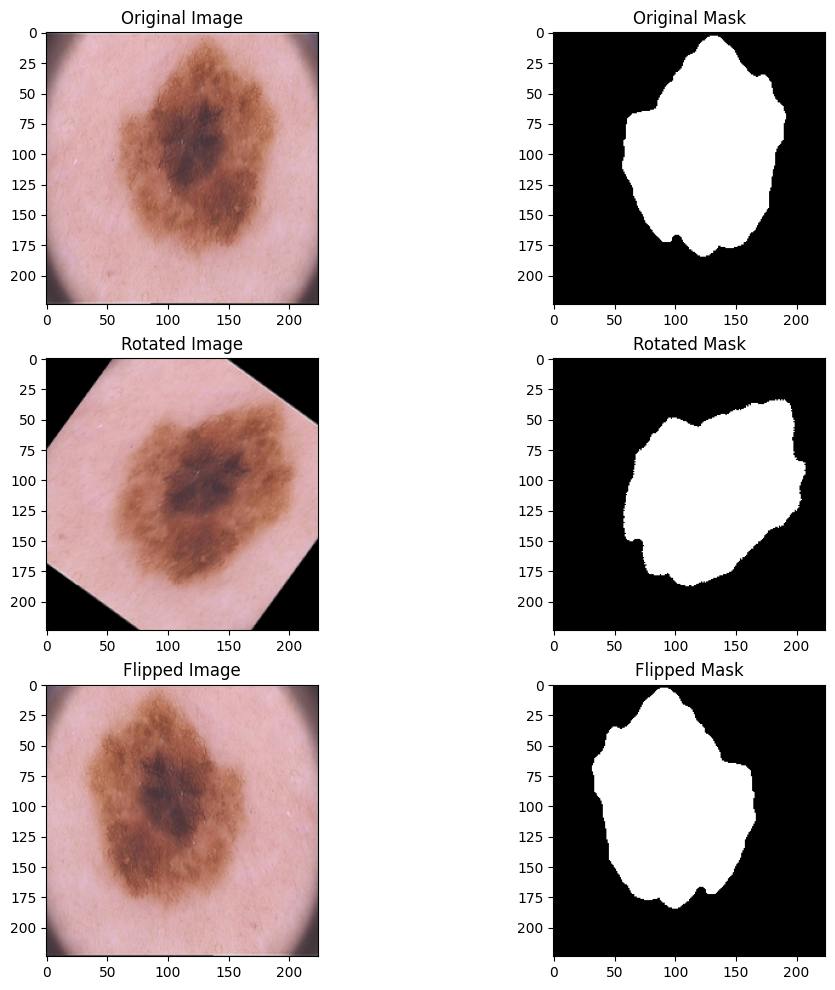

In [20]:
img_num = 7

plt.figure(figsize=(12,12))

plt.subplot(3,2,1)
plt.imshow(x_train[img_num])
plt.title('Original Image')

plt.subplot(3,2,2)
plt.imshow(y_train[img_num], plt.cm.binary_r)
plt.title('Original Mask')

plt.subplot(3,2,3)
plt.imshow(x_rotated[img_num])
plt.title('Rotated Image')

plt.subplot(3,2,4)
plt.imshow(y_rotated[img_num], plt.cm.binary_r)
plt.title('Rotated Mask')

plt.subplot(3,2,5)
plt.imshow(x_flipped[img_num])
plt.title('Flipped Image')

plt.subplot(3,2,6)
plt.imshow(y_flipped[img_num], plt.cm.binary_r)
plt.title('Flipped Mask')

plt.show()

Now we join all the augmentations image arrays to the original training arrays.

In [21]:
x_train_full = np.concatenate([x_train, x_rotated, x_flipped])
y_train_full = np.concatenate([y_train, y_rotated, y_flipped])

#### Making a Validation Set  
We will split our full training set into train and validation set.
Validation dataset is used to validate the performance after each epoch.

In [22]:
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size = 0.20, random_state = 101)

In [23]:
print("Length of the Training Set   : {}".format(len(x_train)))
print("Length of the Test Set       : {}".format(len(x_test)))
print("Length of the Validation Set : {}".format(len(x_val)))

Length of the Training Set   : 360
Length of the Test Set       : 50
Length of the Validation Set : 90


## The Model

#

In [24]:
# Number of image channels (for example 3 in case of RGB, or 1 for grayscale images)
INPUT_CHANNELS = 3
# Number of output masks (1 in case you predict only one type of objects)
OUTPUT_MASK_CHANNELS = 1
# Pretrained weights

In [25]:
# https://youtu.be/L5iV5BHkMzM

"""
Attention U-net:
https://arxiv.org/pdf/1804.03999.pdf

Recurrent residual Unet (R2U-Net) paper
https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
(Check fig 4.)

Note: Batch normalization should be performed over channels after a convolution, 
In the following code axis is set to 3 as our inputs are of shape 
[None, height, width, channel]. Channel is axis=3.

Original code from below link but heavily modified.
https://github.com/MoleImg/Attention_UNet/blob/master/AttResUNet.py
"""

import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K

##############################################################
'''
Useful blocks to build Unet
conv - BN - Activation - conv - BN - Activation - Dropout (if enabled)
'''


def conv_block(x, filter_size, size, dropout, batch_norm=False):
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv


def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape 
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def res_conv_block(x, filter_size, size, dropout, batch_norm=False, dilation_rate=1):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).
    
    1. conv - BN - Activation - conv - BN - Activation 
                                          - shortcut  - BN - shortcut+BN
                                          
    2. conv - BN - Activation - conv - BN   
                                     - shortcut  - BN - shortcut+BN - Activation                                     
    
    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = layers.Conv2D(size, (filter_size, filter_size), 
                         padding='same',
                         dilation_rate=dilation_rate)(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)
    
    conv = layers.Conv2D(size, (filter_size, filter_size), 
                         padding='same',
                         dilation_rate=dilation_rate)(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1),
                             padding='same',
                             dilation_rate=dilation_rate)(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn




def UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True, activation='sigmoid'):
    '''
    UNet
    '''
    # network structure
    FILTER_NUM = 64 # number of filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    

    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
   
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, conv_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, conv_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, conv_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
   
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, conv_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
   
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation(activation)(conv_final)  #Change to softmax for multichannel
    print('Activation: ', activation)
    # Model 
    model = models.Model(inputs, conv_final, name="UNet")
    # print(model.summary())
    return model



def Attention_UNet(input_shape, 
                   NUM_CLASSES=1,
                   FILTER_NUM=64,
                   dropout_rate=0.0, 
                   batch_norm=True, 
                   activation='sigmoid'):
    '''
    Attention UNet
    '''

    # network structure
    # FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    
    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)

    # conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel
    conv_final = layers.Activation(activation)(conv_final)  #Change to softmax for multichannel
    print("Activation: ", activation)
    # Model integration
    model = models.Model(inputs, conv_final, name="Attention_UNet")
    return model

def Attention_ResUNet(input_shape,
                      NUM_CLASSES=2, 
                      FILTER_NUM=64,
                      FILTER_SIZE=3,
                      dropout_rate=0.0, 
                      batch_norm=True,
                      activation='sigmoid'):
    '''
    Rsidual UNet, with attention 
    
    '''
    # network structure
    # FILTER_NUM = 64 # number of basic filters for the first layer
    # FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    print(input_shape)
    # if input_shape == (None, None, 3):
    #     inputs = layers.Input(input_shape)
    # else:   
    inputs = layers.Input(input_shape, dtype=tf.float32)
        
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation(activation)(conv_final)  #Change to softmax for multichannel
    print("Activation: ", activation)
    # Model integration
    model = models.Model(inputs, conv_final, name="Attention_Res_UNet")
    # print(model.summary())
    return model



def Dilated_Attention_ResUNet(input_shape,
                      NUM_CLASSES=2, 
                      FILTER_NUM=64,
                      FILTER_SIZE=3,
                      dropout_rate=0.0, 
                      batch_norm=True,
                      activation='sigmoid',
                      dilation_rates=[1, 3, 5, 7, 11, 13]):
    '''
    Dilated Residual UNet, with attention 
    
    '''
    # network structure
    # FILTER_NUM = 64 # number of basic filters for the first layer
    # FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    print(input_shape)
    # if input_shape == (None, None, 3):
    #     inputs = layers.Input(input_shape)
    # else:   
    inputs = layers.Input(input_shape, dtype=tf.float32)
        
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, 
                              batch_norm,
                              dilation_rate=dilation_rates[0])
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    print(conv_128.shape, pool_64.shape)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate,
                             batch_norm,
                             dilation_rate=dilation_rates[1])
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    print(conv_64.shape, pool_32.shape)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, 
                             batch_norm,
                             dilation_rate=dilation_rates[2])
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    print(conv_32.shape, pool_16.shape)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, 
                             batch_norm,
                             dilation_rate=dilation_rates[3])
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    print(conv_16.shape, pool_8.shape)
    
    # DownRes 5
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, 
                             batch_norm,
                             dilation_rate=dilation_rates[4])
    pool_4 = layers.MaxPooling2D(pool_size=(2,2))(conv_8)
    print(conv_8.shape, pool_4.shape)
    
    # DownRes 6, convolution only
    conv_4 = res_conv_block(pool_4, FILTER_SIZE, 32*FILTER_NUM, dropout_rate,
                            batch_norm,
                            dilation_rate=dilation_rates[5])
    print(conv_4.shape)
    
    # Upsampling layers
    gating_8 = gating_signal(conv_4, 16*FILTER_NUM, batch_norm)
    att_8 = attention_block(conv_8, gating_8, 16*FILTER_NUM)
    up_8 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_4)
    up_8 = layers.concatenate([up_8, att_8], axis=axis)
    up_conv_8 = res_conv_block(up_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, 
                                batch_norm,
                                dilation_rate=dilation_rates[4])
    print('gate: ', gating_8.shape)
    print('att: ', att_8.shape)
    print('up_sampling: ', up_conv_8.shape)
    
    
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, 
                                batch_norm,
                                dilation_rate=dilation_rates[3])
    
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, 
                                batch_norm,
                                dilation_rate=dilation_rates[2])
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, 
                                batch_norm,
                                dilation_rate=dilation_rates[1])
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, 
                                 batch_norm,
                                 dilation_rate=dilation_rates[0])

    # 1*1 convolutional layers
    
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation(activation)(conv_final)  #Change to softmax for multichannel
    print("Activation: ", activation)
    pred = Reshape((224,224))(conv_final)
    # Model integration
    model = models.Model(inputs, pred, name="Dilated_Attention_Res_UNet")
    # print(model.summary())
    return model

#%%
# input_shape = (256,256,3)
# dilation_rates=[1, 3, 5, 7, 11, 13]
# input_shape = (None,None,3)

#%%
# unet_model = UNet(input_shape, NUM_CLASSES=3, 
#                   dropout_rate=0.2, batch_norm=True)
# unet_model.summary()


#%%
# darunet = Dilated_Attention_ResUNet(input_shape,
#                       NUM_CLASSES=OUTPUT_MASK_CHANNELS, 
#                       FILTER_NUM=64,
#                       # FILTER_SIZE=3,
#                       dropout_rate=0.25, 
#                       # batch_norm=True,
#                       #activation='softmax',
#                       dilation_rates=dilation_rates
#                       )

# darunet.summary()

def double_conv_layer(x, size, dropout=0.40, batch_norm=True):
    if K.image_dim_ordering() == 'th':
        axis = 1
    else:
        axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv


def UNET_224(epochs_num, savename):
    dropout_val=0.50
    if K.image_dim_ordering() == 'th':
        inputs = Input((INPUT_CHANNELS, 224, 224))
        axis = 1
    else:
        inputs = Input((224, 224, INPUT_CHANNELS))
        axis = 3
    filters = 32

    conv_224 = double_conv_layer(inputs, filters)
    pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

    conv_112 = double_conv_layer(pool_112, 2*filters)
    pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

    conv_56 = double_conv_layer(pool_56, 4*filters)
    pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

    conv_28 = double_conv_layer(pool_28, 8*filters)
    pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

    conv_14 = double_conv_layer(pool_14, 16*filters)
    pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

    conv_7 = double_conv_layer(pool_7, 32*filters)

    up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
    up_conv_14 = double_conv_layer(up_14, 16*filters)

    up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
    up_conv_28 = double_conv_layer(up_28, 8*filters)

    up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
    up_conv_56 = double_conv_layer(up_56, 4*filters)

    up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
    up_conv_112 = double_conv_layer(up_112, 2*filters)

    up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
    up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

    conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
    conv_final = Activation('sigmoid')(conv_final)
    pred = Reshape((224,224))(conv_final)
    model = Model(inputs, pred, name="UNET_224")
    model.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance]
                  , metrics=[iou, dice_coe, precision, recall, accuracy])
    model.summary()
    hist = model.fit(x_train, y_train, epochs= epochs_num, batch_size= 18,validation_data=(x_val, y_val), verbose=1)
    model.save(savename)
    return model, hist

### For 1 epoch

model_0 = Model(inputs, pred, name="UNET_224")
model_0.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance]
                  , metrics=[iou, dice_coe, precision, recall, accuracy])

#### After 100 epochs

model, hist = UNET_224(epochs_num= 100, savename= 'unet_100_epoch.h5')

model_1 = Model(inputs, pred, name="UNET_224")
model_1.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance]
                  , metrics=[iou, dice_coe, precision, recall, accuracy])

model_1.load_weights('unet_100_epoch.h5')

In [26]:
input_shape = (224,224,3)
dilation_rates=[1, 3, 5, 7, 11, 13]

model_1 = Dilated_Attention_ResUNet(input_shape,
                      NUM_CLASSES=OUTPUT_MASK_CHANNELS, 
                      FILTER_NUM=64,
                      # FILTER_SIZE=3,
                      dropout_rate=0.25, 
                      # batch_norm=True,
                      #activation='softmax',
                      dilation_rates=dilation_rates
                      )

model_1.summary()

(224, 224, 3)
(None, 224, 224, 64) (None, 112, 112, 64)
(None, 112, 112, 128) (None, 56, 56, 128)
(None, 56, 56, 256) (None, 28, 28, 256)
(None, 28, 28, 512) (None, 14, 14, 512)
(None, 14, 14, 1024) (None, 7, 7, 1024)
(None, 7, 7, 2048)
gate:  (None, 7, 7, 1024)
att:  (None, 14, 14, 1024)
up_sampling:  (None, 14, 14, 1024)
Activation:  sigmoid
Model: "Dilated_Attention_Res_UNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Ba

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

epochs = epochs_num = 120
batch_size = 8
init_lr = 0.003

backup_model_best = 'Skin-Cancer-Segmentation-Dilated-ARU-Net-100ep-2023-12-22.hdf5'

print('\nbackup_model_best: ', backup_model_best)
mcp2 = ModelCheckpoint(backup_model_best, save_best_only=True) 

reLR = ReduceLROnPlateau(
                  # monitor='val_iou_coef1',
                  # monitor='val_dice_coef2',
                  monitor='val_jaccard_distance',
                  # monitor='val_total_loss',
                  factor=0.8,
                  patience=5,
                  verbose=1,
                  mode='auto',
                  # min_lr = 0.00001,#1e-5
                  # min_lr = init_lr/100,
                  min_lr = init_lr / epochs,
                )


backup_model_best:  Skin-Cancer-Segmentation-Dilated-ARU-Net-100ep-2023-12-22.hdf5


In [28]:
from tensorflow.keras.optimizers import Adadelta, Nadam ,Adam
model_1.compile(optimizer= Adam(lr = 0.003), 
                loss= [jaccard_distance],
                metrics=[
                    iou, 
                    dice_coe, precision, recall, accuracy
                ])

In [29]:
x_train.shape, y_train.shape, batch_size, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((360, 224, 224, 3),
 (360, 224, 224),
 8,
 (90, 224, 224, 3),
 (90, 224, 224),
 (50, 224, 224, 3),
 (50, 224, 224))

In [30]:
y_train_1 = np.expand_dims(y_train, axis=3)
y_val_1 = np.expand_dims(y_val, axis=3)
y_test_1 = np.expand_dims(y_test, axis=3)

In [31]:
x_train.shape, y_train_1.shape, batch_size, x_val.shape, y_val_1.shape, x_test.shape, y_test_1.shape

((360, 224, 224, 3),
 (360, 224, 224, 1),
 8,
 (90, 224, 224, 3),
 (90, 224, 224, 1),
 (50, 224, 224, 3),
 (50, 224, 224, 1))

In [32]:
!pip install livelossplot

In [33]:
from livelossplot import PlotLossesKeras

### Perform Training

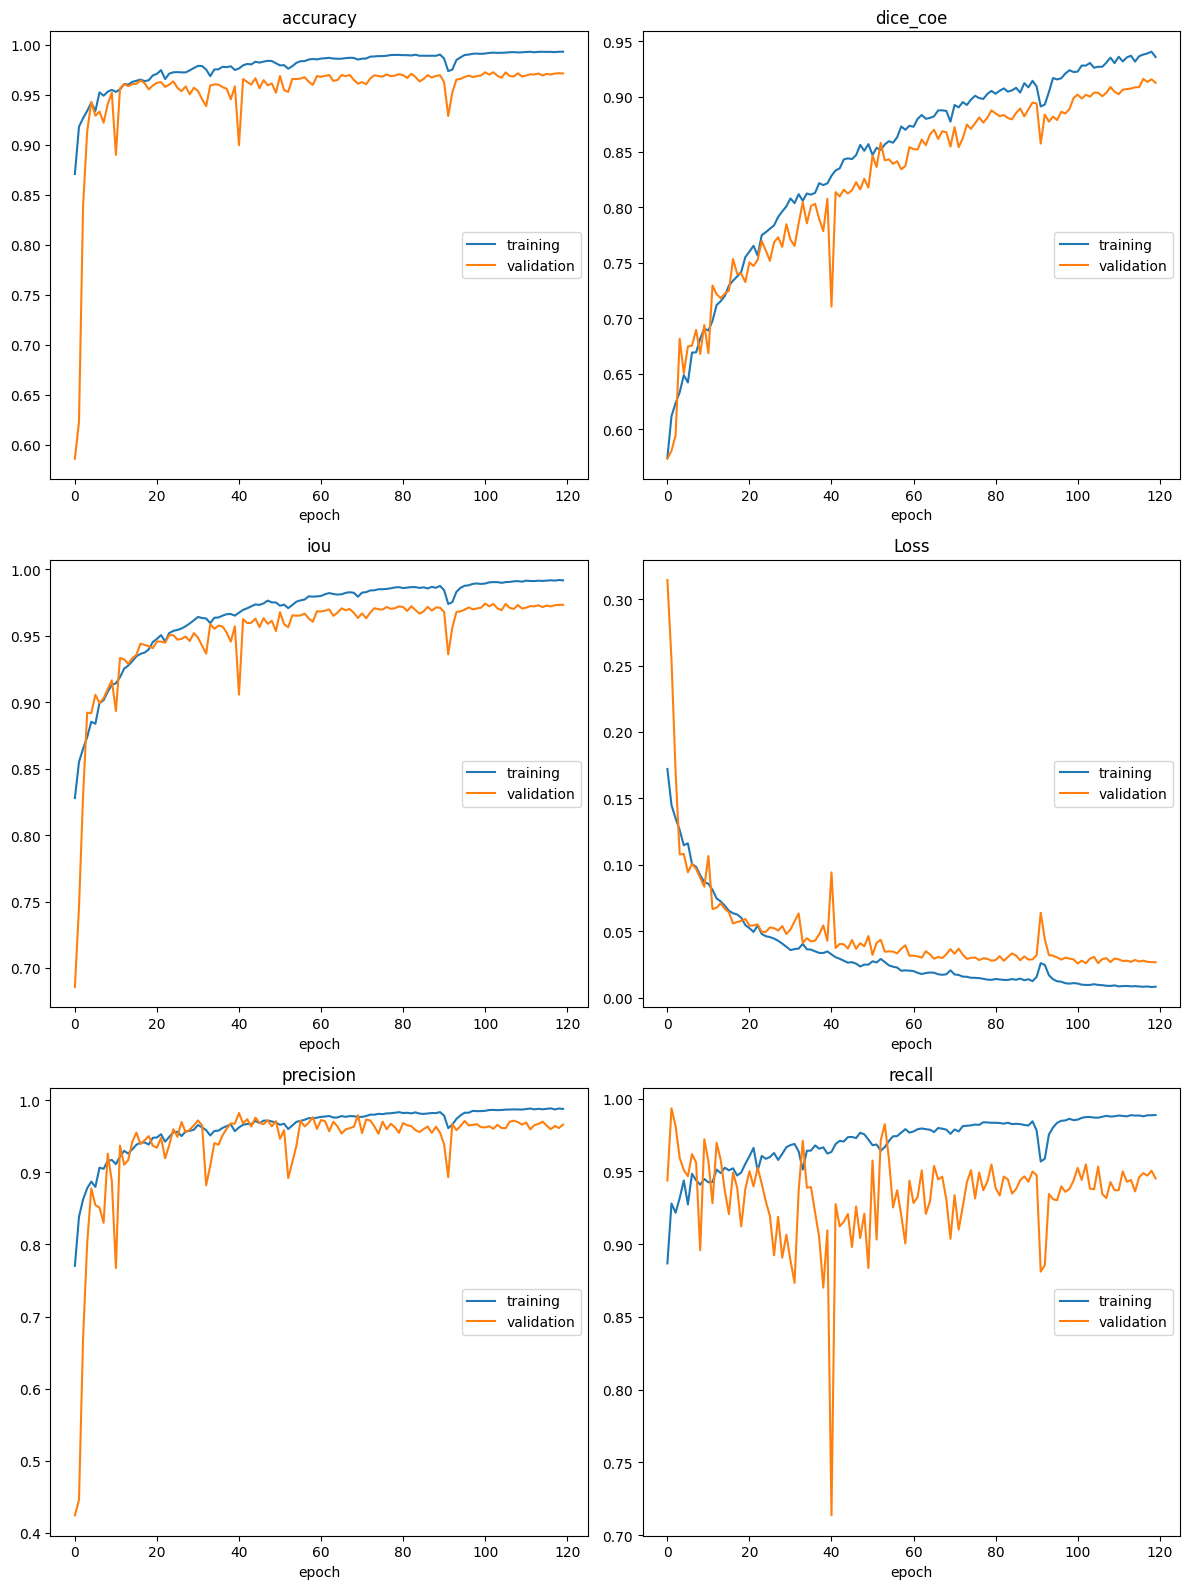

accuracy
	training         	 (min:    0.871, max:    0.993, cur:    0.993)
	validation       	 (min:    0.586, max:    0.972, cur:    0.971)
dice_coe
	training         	 (min:    0.574, max:    0.940, cur:    0.936)
	validation       	 (min:    0.574, max:    0.916, cur:    0.912)
iou
	training         	 (min:    0.828, max:    0.992, cur:    0.992)
	validation       	 (min:    0.686, max:    0.974, cur:    0.973)
Loss
	training         	 (min:    0.008, max:    0.172, cur:    0.008)
	validation       	 (min:    0.026, max:    0.314, cur:    0.027)
precision
	training         	 (min:    0.770, max:    0.989, cur:    0.988)
	validation       	 (min:    0.424, max:    0.982, cur:    0.966)
recall
	training         	 (min:    0.887, max:    0.989, cur:    0.989)
	validation       	 (min:    0.714, max:    0.993, cur:    0.945)
45/45 - 26s - loss: 0.0083 - iou: 0.9917 - dice_coe: 0.9355 - precision: 0.9880 - recall: 0.9887 - accuracy: 0.9928 - val_loss: 0.0267 - val_iou: 0.9733 - val_dice_

In [34]:
hist = model_1.fit(x_train, y_train,
                 epochs=epochs_num,
                 batch_size=batch_size,
                 validation_data=(x_val, y_val),
                 callbacks = [
                     PlotLossesKeras(),
                     mcp2,
                     reLR,
                 ],
                 verbose=2)

### Plotting Training Stats

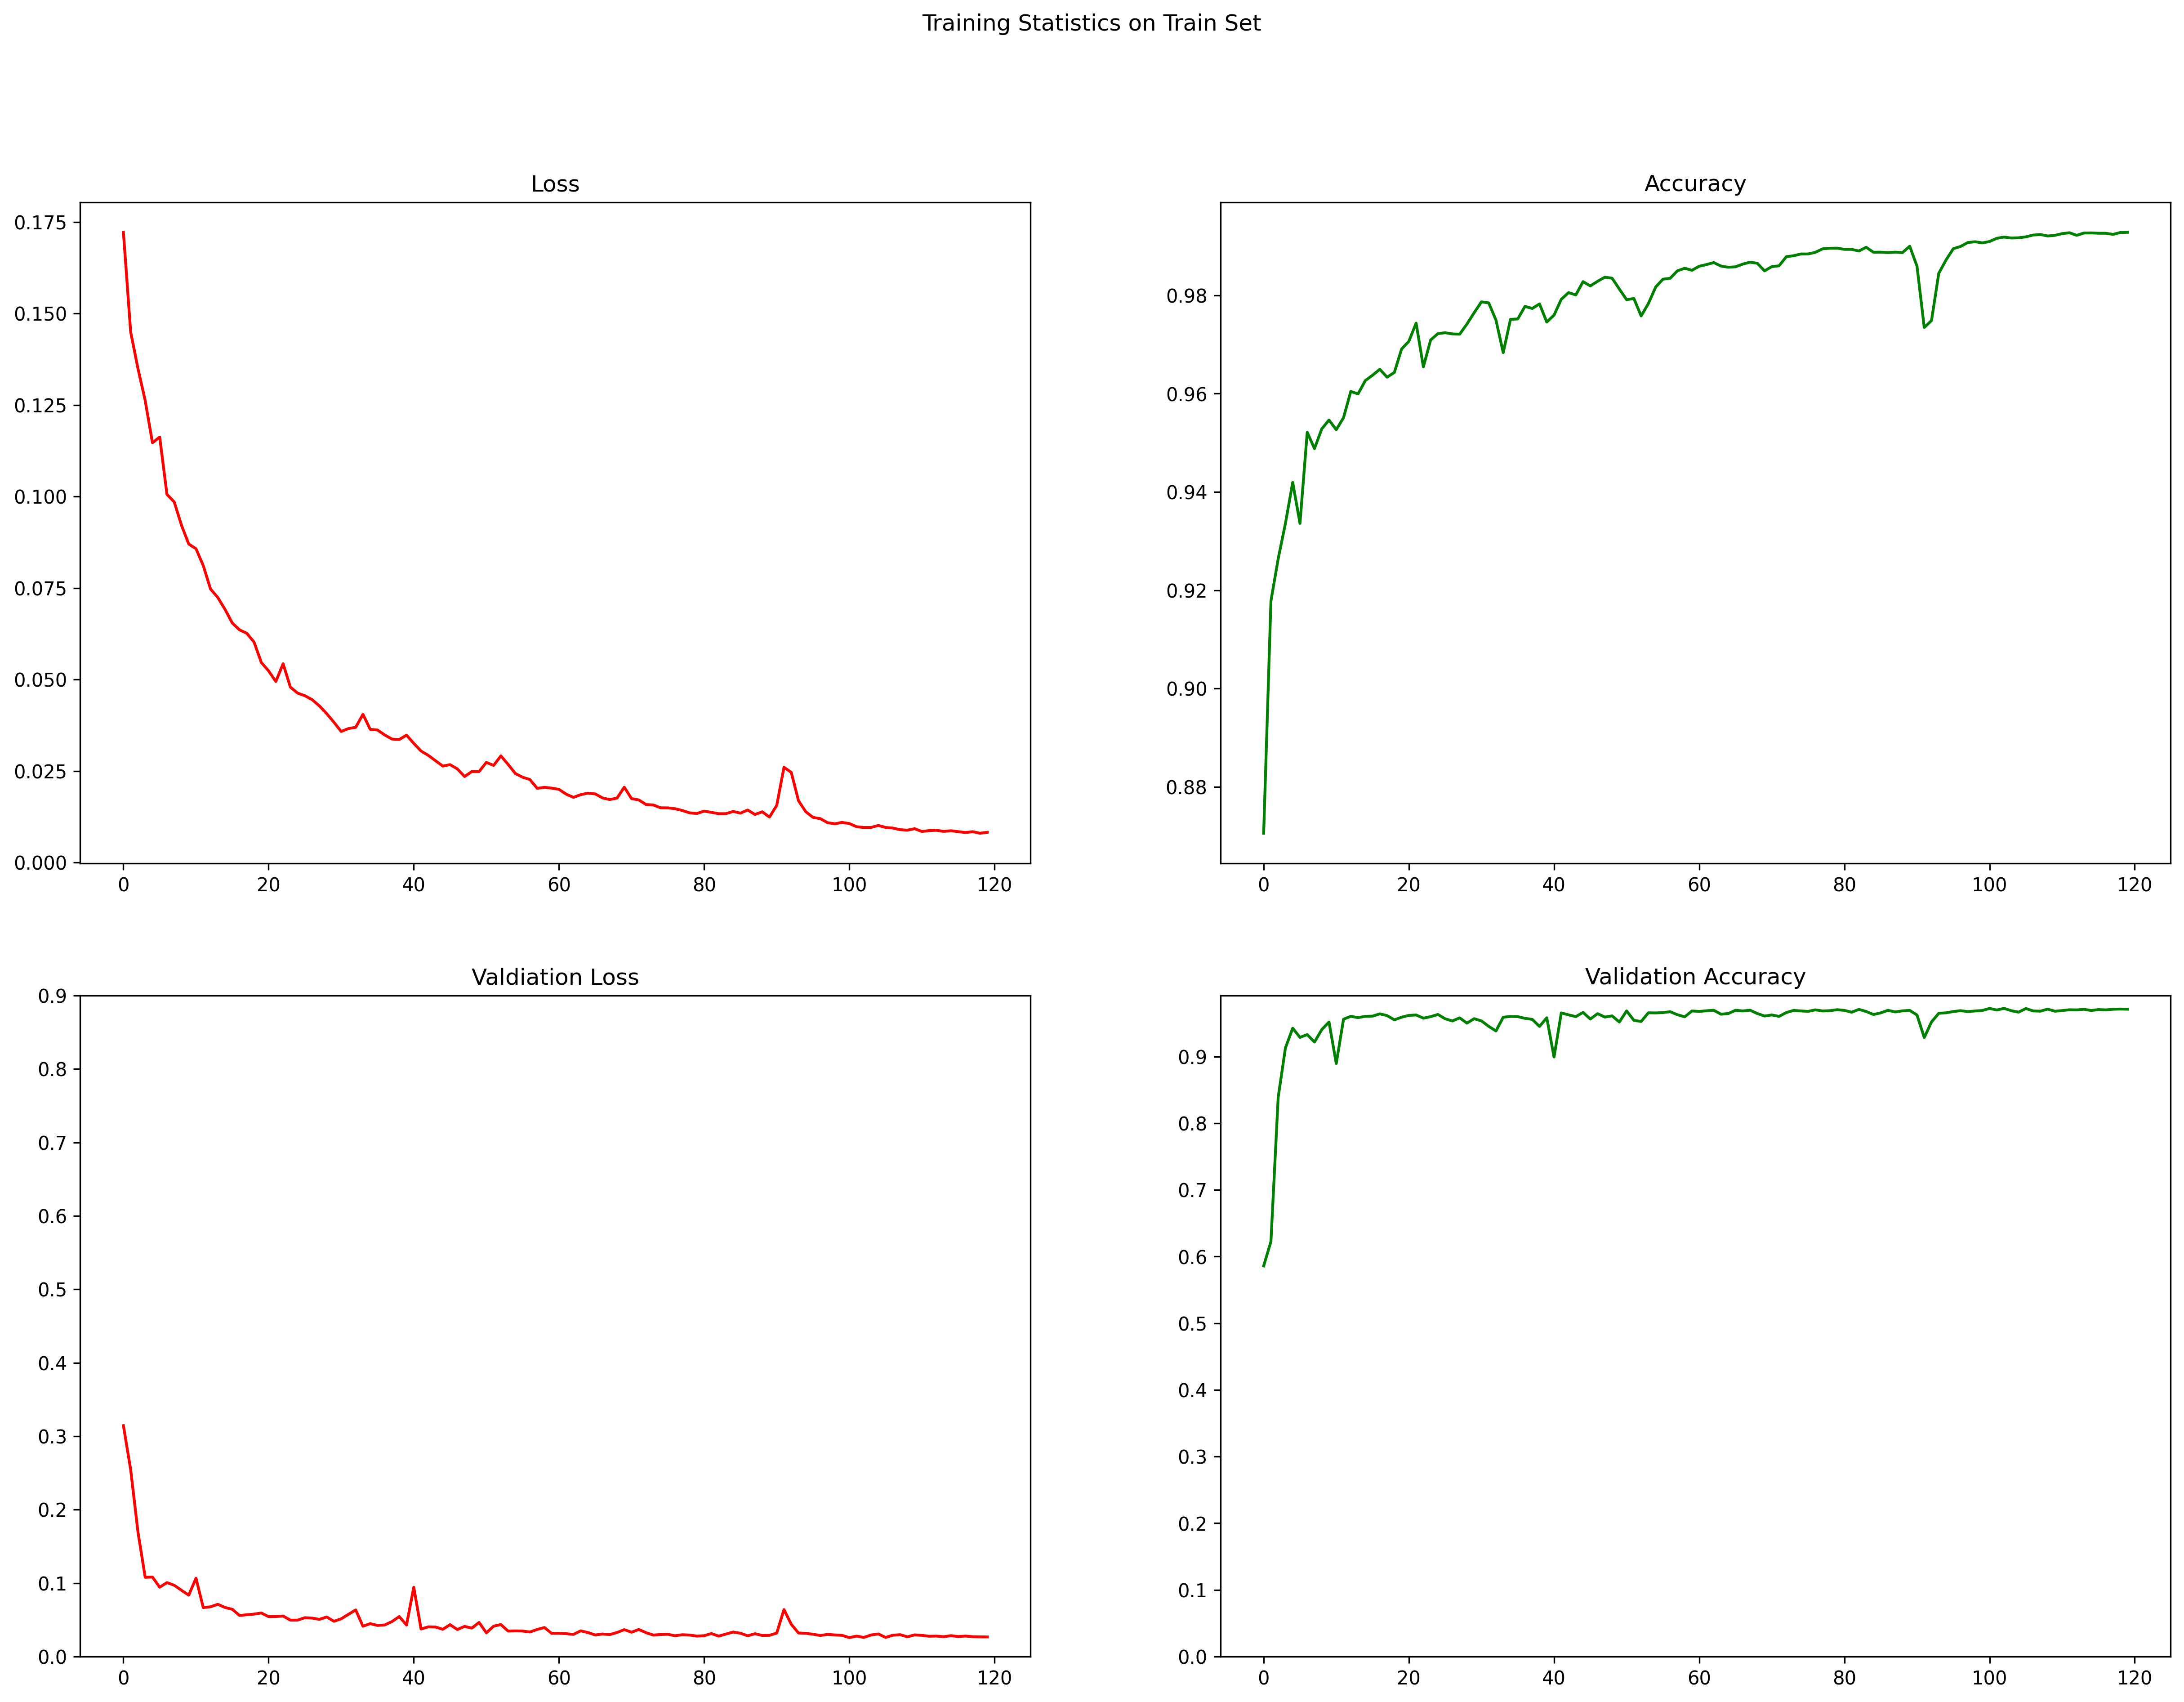

In [35]:
plt.figure(figsize=(20, 14), dpi=300)

plt.suptitle('Training Statistics on Train Set')

plt.subplot(2,2,1)
plt.plot(hist.history['loss'], 'red')
plt.title('Loss')

plt.subplot(2,2,2)
plt.plot(hist.history['accuracy'], 'green')
plt.title('Accuracy')

plt.subplot(2,2,3)
plt.plot(hist.history['val_loss'], 'red')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Valdiation Loss')

plt.subplot(2,2,4)
plt.plot(hist.history['val_accuracy'], 'green')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Validation Accuracy')

plt.show()

In [36]:
model_history_df = pd.DataFrame(hist.history) 
model_name = 'DARUN'
history_file = f'{model_name}_history_df.csv'
# history_file_path = os.path.join(model_name, history_file)
with open(history_file, mode='w') as f:
    model_history_df.to_csv(f)  
print("\nSaved: ", history_file)

#%%
# if LOGSCREEN==True:

history1 = hist


Saved:  DARUN_history_df.csv


In [37]:
 history1.history.keys()

dict_keys(['loss', 'iou', 'dice_coe', 'precision', 'recall', 'accuracy', 'val_loss', 'val_iou', 'val_dice_coe', 'val_precision', 'val_recall', 'val_accuracy', 'lr'])

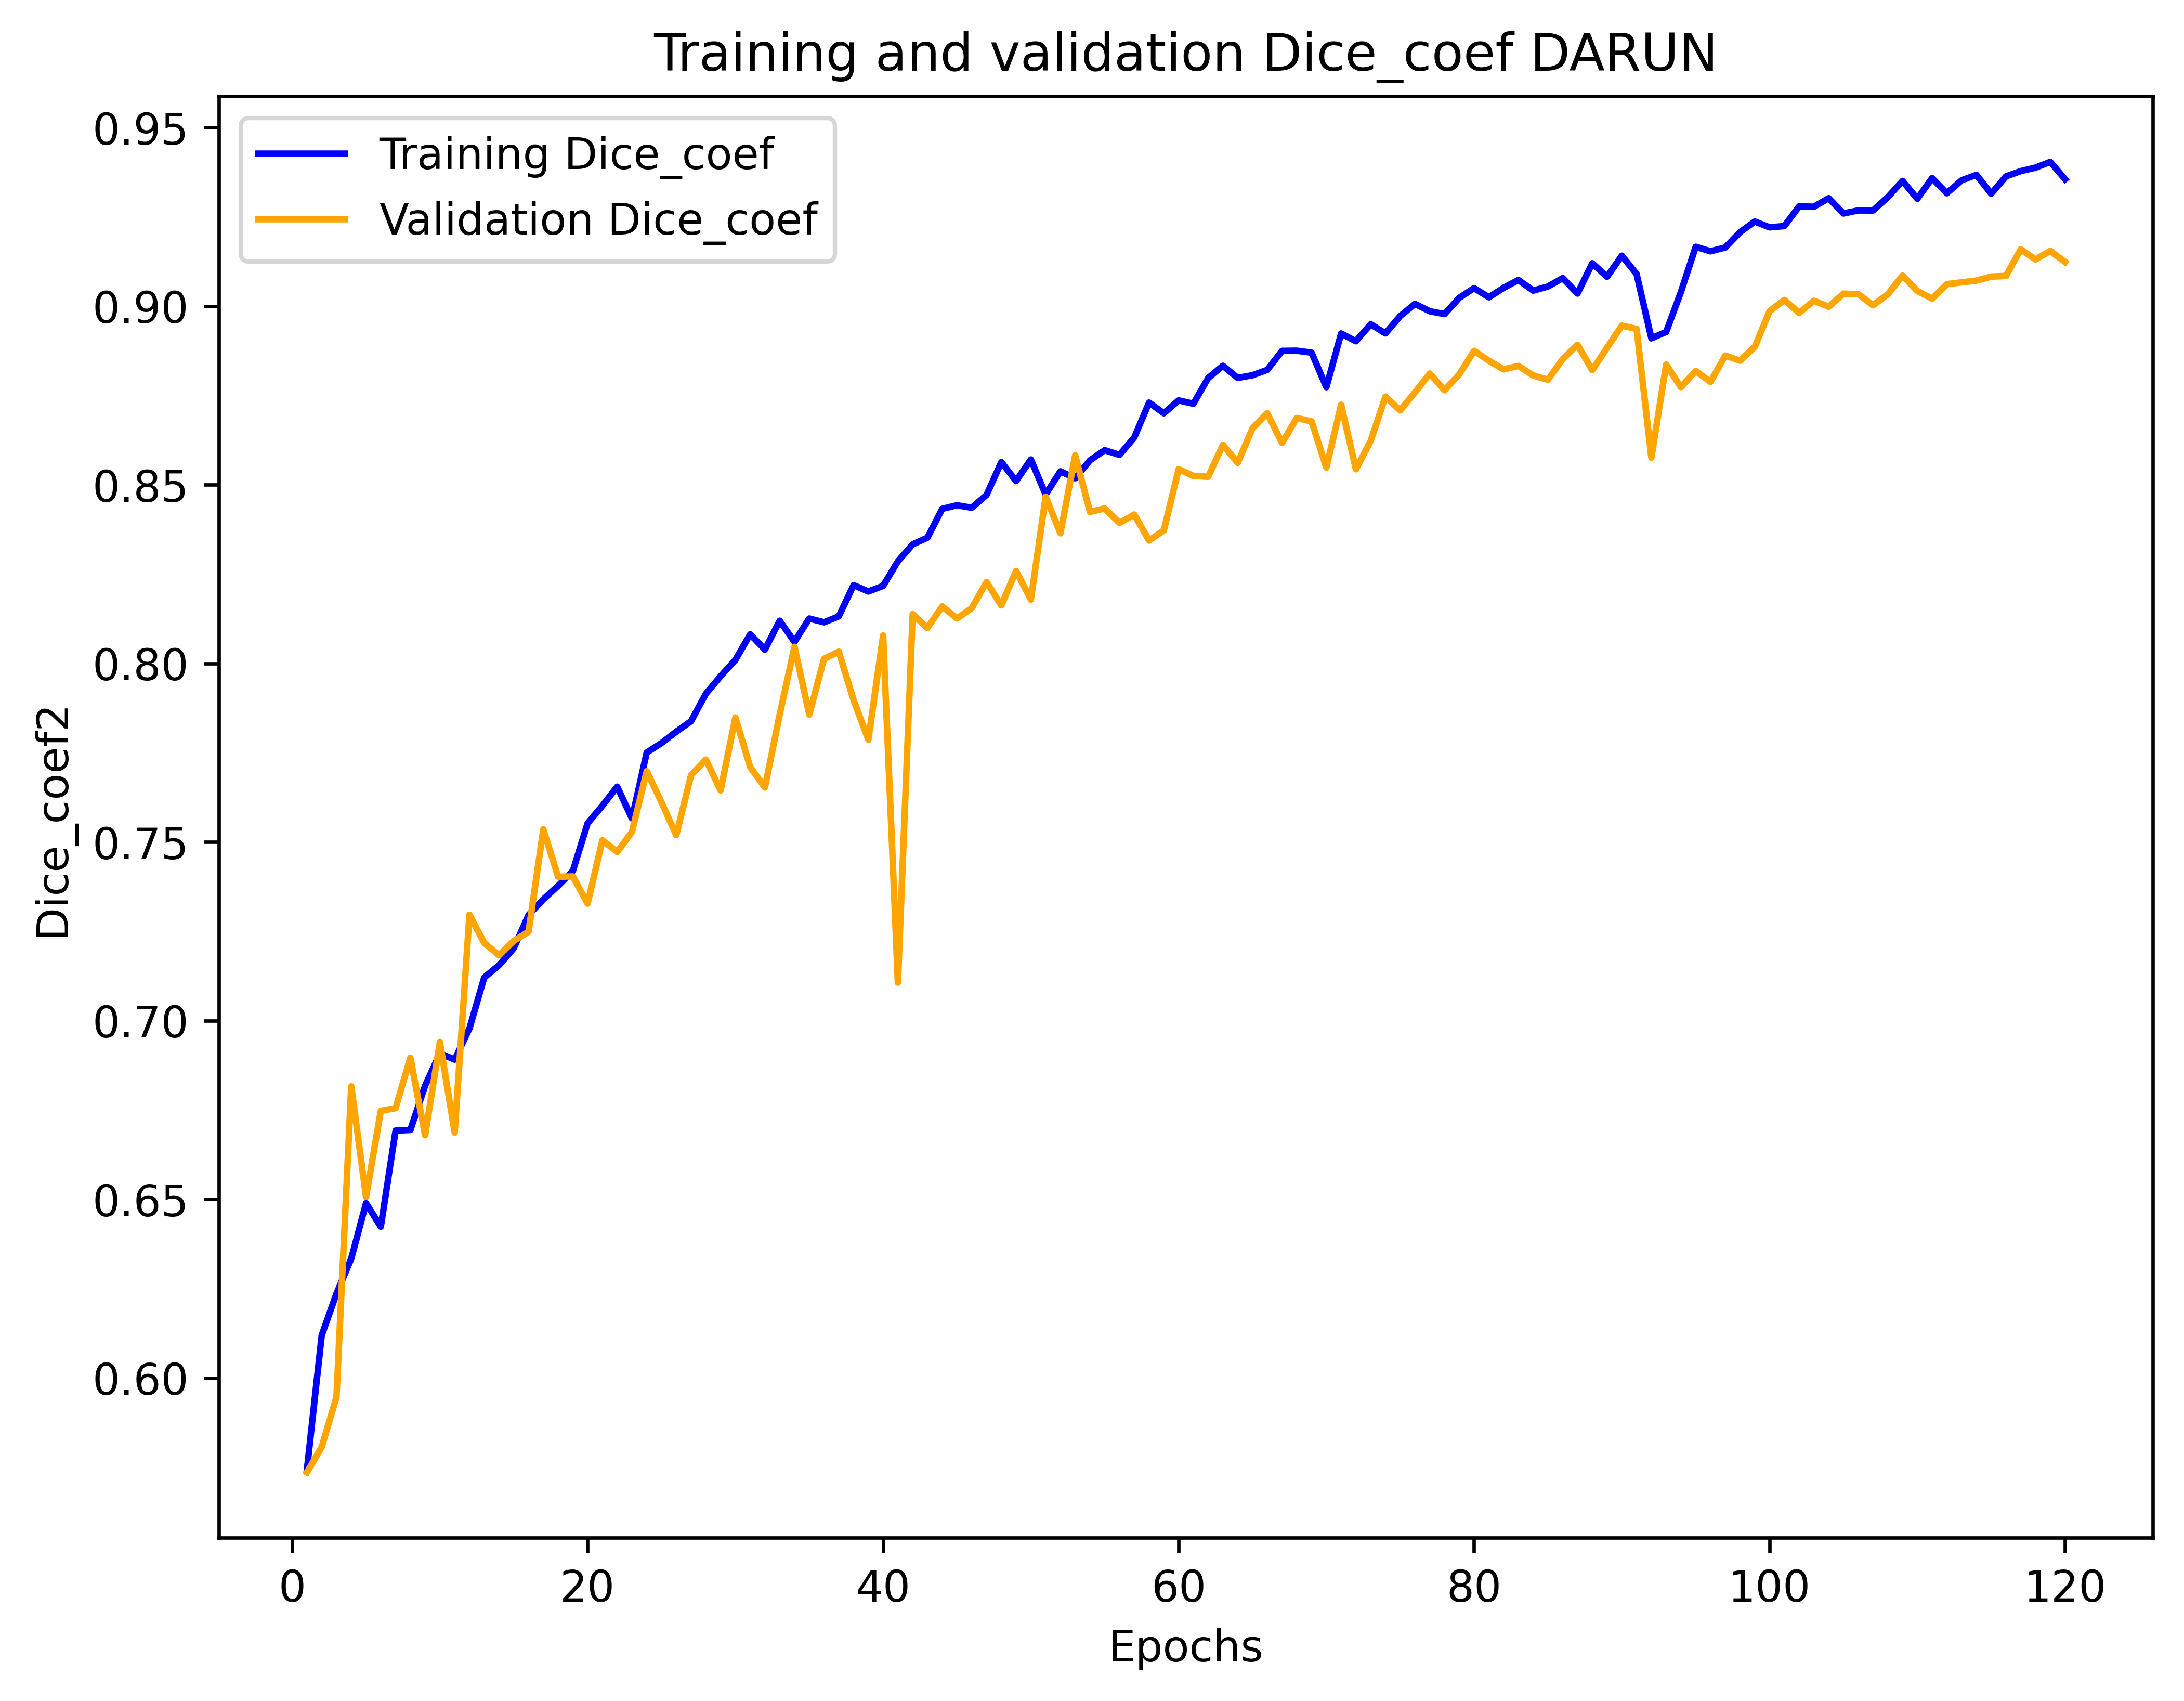

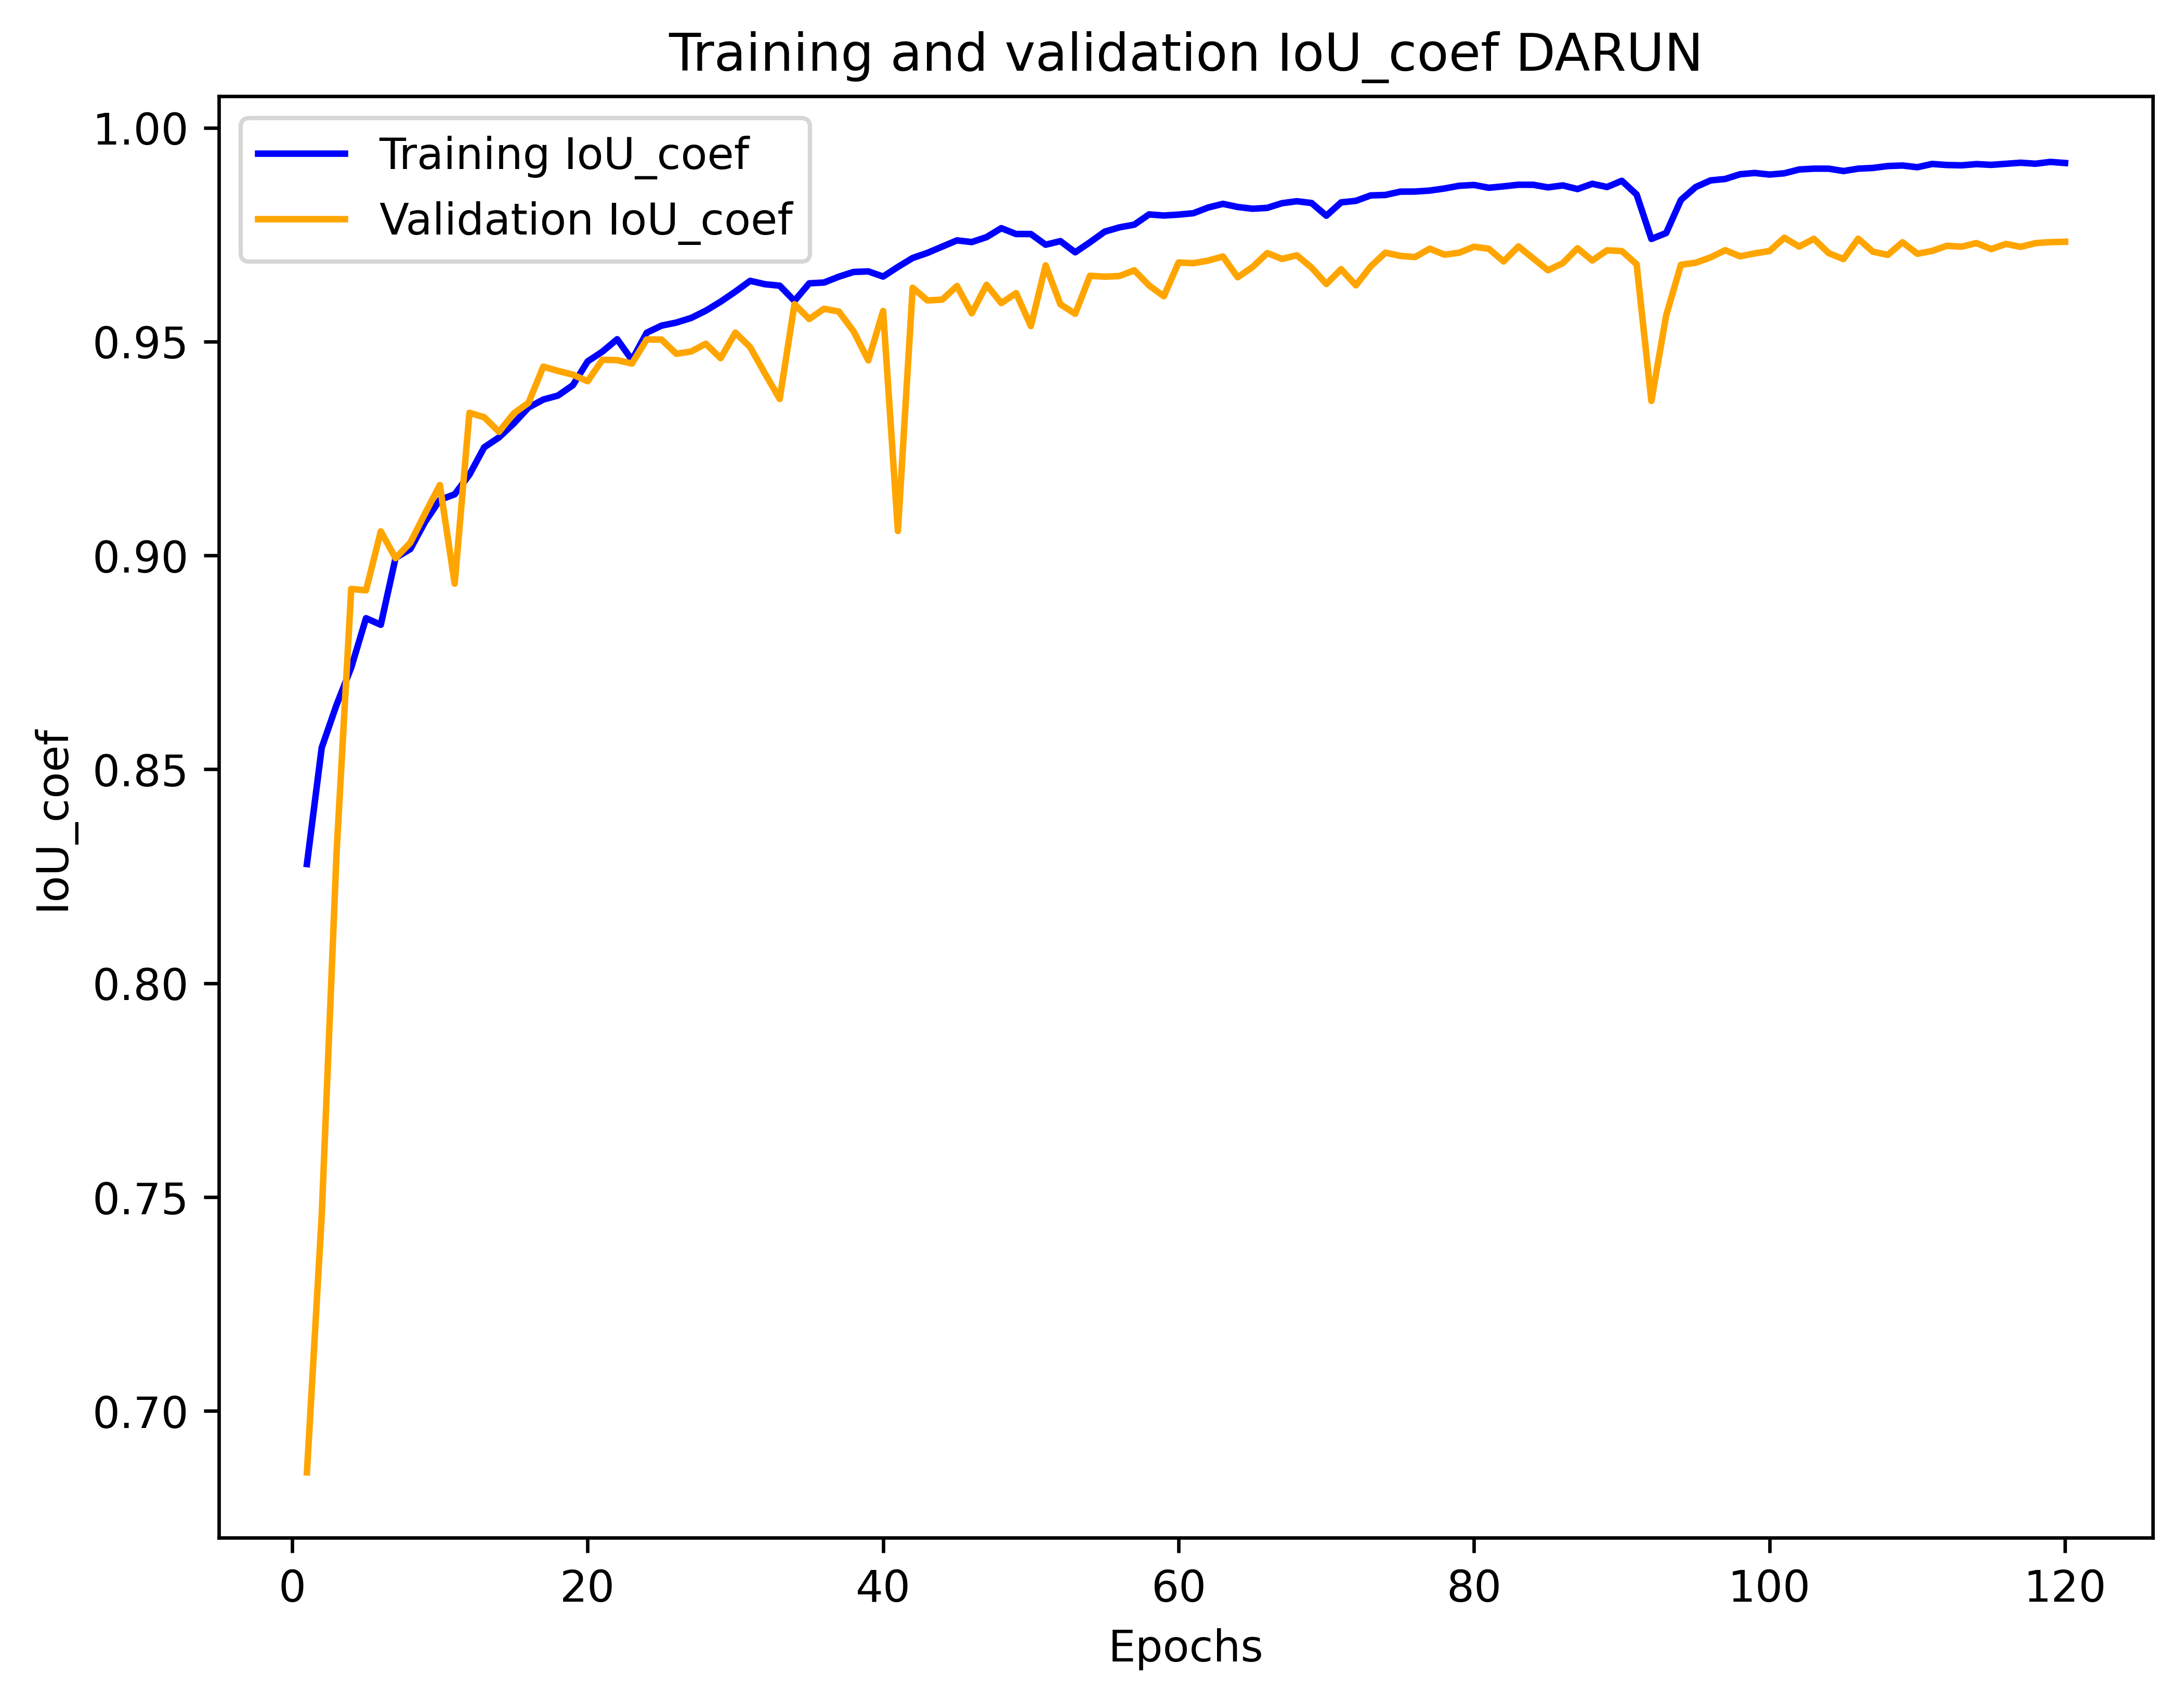

In [38]:
data_note = model_name

#%plot the training and validation accuracy and loss at each epoch

loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(8, 6), dpi=600)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss ' + data_note)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
loss_file = f'loss-{model_name}.png'
# loss_file_path = os.path.join(model_name, loss_file)
fig.savefig(loss_file)

#%%
acc = history1.history['dice_coe']
val_acc = history1.history['val_dice_coe']
fig = plt.figure(figsize=(8, 6), dpi=600)
plt.plot(epochs, acc, 'b', label='Training Dice_coef')
plt.plot(epochs, val_acc, 'orange', label='Validation Dice_coef')
plt.title('Training and validation Dice_coef ' + data_note)
plt.xlabel('Epochs')
plt.ylabel('Dice_coef2')
plt.legend()
plt.show()
dice_file_path = f'dice_coef2-{model_name}.png'
# dice_file_path = os.path.join(model_name, dice_file)
fig.savefig(dice_file_path)

#%%
acc = history1.history['iou']
val_acc = history1.history['val_iou']
fig = plt.figure(figsize=(8, 6), dpi=600)
plt.plot(epochs, acc, 'b', label='Training IoU_coef')
plt.plot(epochs, val_acc, 'orange', label='Validation IoU_coef')
plt.title('Training and validation IoU_coef ' + data_note)
plt.xlabel('Epochs')
plt.ylabel('IoU_coef')
plt.legend()
plt.show()
iou_file_path = f'iou-{model_name}.png'
# iou_file_path = os.path.join(model_name, iou_file)
fig.savefig(iou_file_path)

In [39]:
from tensorflow.keras.models import Model, load_model

# backup_model_best = '/kaggle/input/skin-cancer-segmentation-dilated-aru-net-100ep/Skin-Cancer-Segmentation-Dilated-ARU-Net-100ep.hdf5'

print('\nbackup_model_best: ', backup_model_best)
model_1 = load_model(backup_model_best, compile=False)
# print(best_model.summary())
print('\nLoaded: ' , backup_model_best)


backup_model_best:  Skin-Cancer-Segmentation-Dilated-ARU-Net-100ep-2023-12-22.hdf5

Loaded:  Skin-Cancer-Segmentation-Dilated-ARU-Net-100ep-2023-12-22.hdf5


In [40]:
from tensorflow.keras.optimizers import Adadelta, Nadam ,Adam

model_1.compile(optimizer= Adam(lr = 0.003), 
                loss= [jaccard_distance],
                metrics=[
                iou, 
                dice_coe, precision, recall, accuracy
                ])

In [41]:
x_test.shape, y_test.shape

((50, 224, 224, 3), (50, 224, 224))

In [42]:
#Testing the statistics after 100 epochs

print('\n~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
res = model_1.evaluate(x_train, y_train, batch_size= batch_size)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res = model_1.evaluate(x_test, y_test, batch_size= batch_size)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On validation Set---------------------\n')
res = model_1.evaluate(x_val, y_val, batch_size= batch_size)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')


~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~

-------------On Train Set--------------------------

45/45 [==============================] - 9s 153ms/step - loss: 0.0116 - iou: 0.9884 - dice_coe: 0.9272 - precision: 0.9826 - recall: 0.9822 - accuracy: 0.9890
________________________
IOU:       |   98.84  |
Dice Coef: |   92.72  |
Precision: |   98.26  |
Recall:    |   98.22  |
Accuracy:  |   98.90  |
Loss:      |   1.16  |
________________________

-------------On Test  Set--------------------------

7/7 [==============================] - 2s 139ms/step - loss: 0.0341 - iou: 0.9659 - dice_coe: 0.8837 - precision: 0.9449 - recall: 0.9446 - accuracy: 0.9670
________________________
IOU:       |   96.59  |
Dice Coef: |   88.37  |
Precision: |   94.49  |
Recall:    |   94.46  |
Accuracy:  |   96.70  |
Loss:      |   3.41  |
________________________

-------------On validation Set---------------------

12/12 [==============================] - 3s 146ms/step - loss: 0.0257 - iou: 0.

In [43]:
# Pseudo code to calculate IoU for multi-class segmentation
from tensorflow.keras import backend as K
import numpy as np

def calculate_intersection(y_true_class, y_pred_class):
    # Perform element-wise logical "AND" operation to get the intersection
    intersection = np.logical_and(y_true_class, y_pred_class)
    
    # Count the number of True values (pixels) in the intersection mask
    intersection_count = np.sum(intersection)
    
    return intersection_count


def calculate_union(y_true_class, y_pred_class, intersection):
    # Count the number of True values (pixels) in the ground truth and predicted masks
    y_true_count = np.sum(y_true_class)
    y_pred_count = np.sum(y_pred_class)
    
    # Calculate the union using the sizes of the masks and the precomputed intersection
    union = y_true_count + y_pred_count - intersection
    
    return union

def calculate_iou_for_class(y_true, y_pred, class_label, epsilon=1e-6):
    # Get binary masks for the specified class
    y_true_class = (y_true == class_label)
    y_pred_class = (y_pred == class_label)
    
    # Calculate IoU for the specified class using the formula you have (e.g., jacard_coef)
    intersection = calculate_intersection(y_true_class, y_pred_class)
    union = calculate_union(y_true_class, y_pred_class, intersection)
    iou_class = intersection / (union + epsilon)  # Add epsilon for smoothing
    
    return iou_class


def calculate_mean_iou_for_classes(y_true, y_pred, class_labels):
    # Initialize variables to store IoU values and counts for relevant classes
    iou_scores = []
    for class_label in class_labels: 
        # Calculate IoU for the current class label
        iou_class = calculate_iou_for_class(y_true, y_pred, class_label)
        print(class_label, iou_class)
        iou_scores.append(iou_class)
    
    return iou_scores
        # Accumulate IoU and count for the relevant classes
        # iou_sum += iou_class
        # class_count += 1   
    # Calculate mean IoU across relevant classes (excluding 'normal' class)
    # mean_iou = iou_sum / class_count if class_count > 0 else 0.0
    # return mean_iou

#100_eva_3c_test_fold_2.txt
def iou_for_classes(y_true, y_pred, class_labels, smooth=100):
    iou_scores = []
    for class_label in class_labels:
        y_true_class = K.cast(y_true == class_label, dtype=K.floatx())
        y_pred_class = K.cast(y_pred == class_label, dtype=K.floatx())
        
        intersection = K.sum(K.abs(y_true_class * y_pred_class), axis=-1)
        sum_ = K.sum(K.square(K.cast(y_true_class, 'float32')), axis=-1) + \
            K.sum(K.square(K.cast(y_pred_class, 'float32')), axis=-1)

        jac = (intersection + smooth) / (sum_ - intersection + smooth)
        print(class_label, jac)

        iou_scores.append(jac)
    return iou_scores


def calculate_dice_for_classes(y_true, y_pred, class_labels, epsilon=1e-6):
    dice_scores = []
    
    # Iterate through specified class labels (excluding 'normal' class)
    for class_label in class_labels:
        y_true_class = (y_true == class_label)
        y_pred_class = (y_pred == class_label)
        
        intersection = np.sum(y_true_class & y_pred_class)
        dice = (2.0 * intersection) / (np.sum(y_true_class) + np.sum(y_pred_class) + epsilon)
        print(class_label, dice)
        
        dice_scores.append(dice)
    
    # Calculate mean Dice across specified classes
    # mean_dice = np.mean(dice_scores)
    
    return dice_scores

def precision(y_true, y_pred, class_labels):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    precision_scores = []
    for class_label in class_labels:
        y_true_class = K.cast(y_true == class_label, dtype=K.floatx())
        y_pred_class = K.cast(y_pred == class_label, dtype=K.floatx())

        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        print(class_label, precision)

        precision_scores.append(precision)

    return precision_scores


def recall(y_true, y_pred, class_labels):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    recall_scores = []
    for class_label in class_labels:
        y_true_class = K.cast(y_true == class_label, dtype=K.floatx())
        y_pred_class = K.cast(y_pred == class_label, dtype=K.floatx())

        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        print(class_label, precision)

        recall_scores.append(recall)
    return recall_scores

def accuracy(y_true, y_pred, class_labels):
    accuracy_scores = []
    for class_label in class_labels:
        y_true_class = K.cast(y_true == class_label, dtype=K.floatx())
        y_pred_class = K.cast(y_pred == class_label, dtype=K.floatx())
        
        accuracy = K.mean(K.equal(y_true_class, K.round(y_pred_class)))
        print(class_label, accuracy)

        accuracy_scores.append(accuracy)
    return accuracy_scores

In [44]:
x_test.shape, y_test.shape, x_val.shape, y_val.shape, y_test[0]

((50, 224, 224, 3),
 (50, 224, 224),
 (90, 224, 224, 3),
 (90, 224, 224),
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]))

In [45]:
y_pred = model_1.predict(x_val, verbose=1)
y_pred.shape
y_pred = (y_pred > 0.5).astype('uint8')
print(y_pred.shape, y_pred.dtype)
y_pred [0]

y_true = y_val.astype('uint8')
y_true[0]

y_pred.dtype, y_true.dtype

3/3 [==============================] - 56s 12s/step
(90, 224, 224) uint8


(dtype('uint8'), dtype('uint8'))

In [46]:
y_true_masks = y_true.flatten()
y_pred_masks = y_pred.flatten()
class_labels = [0, 1]

print(f"{y_true_masks.shape=}, {y_pred_masks.shape=}") 
y_true_masks.dtype, y_pred_masks.dtype

y_true_masks.shape=(4515840,), y_pred_masks.shape=(4515840,)


(dtype('uint8'), dtype('uint8'))

In [47]:
jac_scores = iou_for_classes(
    y_true_masks,
    y_pred_masks,
    class_labels=[0, 1])
print(f"JAC all classes: {jac_scores}")
print(f"Mean JAC: {np.mean(jac_scores)=}\n")

dice_scores = calculate_dice_for_classes(
    y_true_masks,
    y_pred_masks,
    class_labels)
print(f"Dice all classes: {dice_scores}")
print(f"Mean Dice: {np.mean(dice_scores)=}\n")

precision_scores = precision(
    y_true_masks,
    y_pred_masks,
    class_labels)
print(f"Precision all classes: {precision_scores}")
mean_precision = tf.reduce_mean(precision_scores)
print(f"Mean precision: {mean_precision.numpy()=}\n")

recall_scores = recall(
    y_true_masks,
    y_pred_masks,
    class_labels)
print(f"Recall all classes: {recall_scores}")
mean_recall = tf.reduce_mean(recall_scores)
print(f"Mean recall: {mean_recall.numpy()=}\n")

accuracy_scores = accuracy(
    y_true_masks,
    y_pred_masks,
    class_labels)
print(f"Accuracy all classes: {accuracy_scores}")
mean_accuracy = tf.reduce_mean(accuracy_scores)
print(f"Mean accuracy: {mean_accuracy.numpy()=}\n")

0 tf.Tensor(0.95973116, shape=(), dtype=float32)
1 tf.Tensor(0.91264564, shape=(), dtype=float32)
JAC all classes: [<tf.Tensor: shape=(), dtype=float32, numpy=0.95973116>, <tf.Tensor: shape=(), dtype=float32, numpy=0.91264564>]
Mean JAC: np.mean(jac_scores)=0.9361884

0 0.9794512092437565
1 0.9543247229124464
Dice all classes: [0.9794512092437565, 0.9543247229124464]
Mean Dice: np.mean(dice_scores)=0.9668879660781015

0 tf.Tensor(0.9755309, shape=(), dtype=float32)
1 tf.Tensor(0.9629261, shape=(), dtype=float32)
Precision all classes: [<tf.Tensor: shape=(), dtype=float32, numpy=0.9755309>, <tf.Tensor: shape=(), dtype=float32, numpy=0.9629261>]
Mean precision: mean_precision.numpy()=0.9692285

0 <function precision at 0x7c5af8779f30>
1 <function precision at 0x7c5af8779f30>
Recall all classes: [<tf.Tensor: shape=(), dtype=float32, numpy=0.98340315>, <tf.Tensor: shape=(), dtype=float32, numpy=0.94587564>]
Mean recall: mean_recall.numpy()=0.9646394

0 tf.Tensor(0.97165465, shape=(), dtype

In [48]:
y_pred = model_1.predict(x_test, verbose=1)
y_pred.shape

2/2 [==============================] - 18s 18s/step


(50, 224, 224)

In [49]:
y_pred_test = (y_pred > 0.5).astype('uint8')
print(y_pred_test.shape, y_pred_test.dtype)
y_pred_test[0]

y_test_true = y_test.astype('uint8')
y_test_true[0]

(50, 224, 224) uint8


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

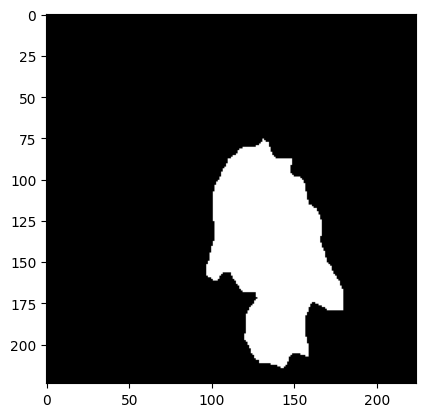

In [50]:
plt.imshow(y_test_true[0], cmap='gray')

In [51]:
y_true_masks = y_test_true.flatten()
y_pred_masks = y_pred_test.flatten()
class_labels = [0, 1]

print(f"{y_true_masks.shape=}, {y_pred_masks.shape=}") 
y_true_masks.dtype, y_pred_masks.dtype

y_true_masks.shape=(2508800,), y_pred_masks.shape=(2508800,)


(dtype('uint8'), dtype('uint8'))

In [52]:
jac_scores = iou_for_classes(
    y_true_masks,
    y_pred_masks,
    class_labels=[0, 1])
print(f"JAC all classes: {jac_scores}")
print(f"Mean JAC: {np.mean(jac_scores)=}\n")

dice_scores = calculate_dice_for_classes(
    y_true_masks,
    y_pred_masks,
    class_labels)
print(f"Dice all classes: {dice_scores}")
print(f"Mean Dice: {np.mean(dice_scores)=}\n")

precision_scores = precision(
    y_true_masks,
    y_pred_masks,
    class_labels)
print(f"Precision all classes: {precision_scores}")
mean_precision = tf.reduce_mean(precision_scores)
print(f"Mean precision: {mean_precision.numpy()=}\n")

recall_scores = recall(
    y_true_masks,
    y_pred_masks,
    class_labels)
print(f"Recall all classes: {recall_scores}")
mean_recall = tf.reduce_mean(recall_scores)
print(f"Mean recall: {mean_recall.numpy()=}\n")

accuracy_scores = accuracy(
    y_true_masks,
    y_pred_masks,
    class_labels)
print(f"Accuracy all classes: {accuracy_scores}")
mean_accuracy = tf.reduce_mean(accuracy_scores)
print(f"Mean accuracy: {mean_accuracy.numpy()=}\n")

0 tf.Tensor(0.9502648, shape=(), dtype=float32)
1 tf.Tensor(0.8935989, shape=(), dtype=float32)
JAC all classes: [<tf.Tensor: shape=(), dtype=float32, numpy=0.9502648>, <tf.Tensor: shape=(), dtype=float32, numpy=0.8935989>]
Mean JAC: np.mean(jac_scores)=0.92193186

0 0.9744967586368328
1 0.9438029361395619
Dice all classes: [0.9744967586368328, 0.9438029361395619]
Mean Dice: np.mean(dice_scores)=0.9591498473881974

0 tf.Tensor(0.9726047, shape=(), dtype=float32)
1 tf.Tensor(0.9478661, shape=(), dtype=float32)
Precision all classes: [<tf.Tensor: shape=(), dtype=float32, numpy=0.9726047>, <tf.Tensor: shape=(), dtype=float32, numpy=0.9478661>]
Mean precision: mean_precision.numpy()=0.96023536

0 <function precision at 0x7c5af8779f30>
1 <function precision at 0x7c5af8779f30>
Recall all classes: [<tf.Tensor: shape=(), dtype=float32, numpy=0.9763962>, <tf.Tensor: shape=(), dtype=float32, numpy=0.9397745>]
Mean recall: mean_recall.numpy()=0.95808536

0 tf.Tensor(0.9649155, shape=(), dtype=flo

## Visualising Predicted Lesions

We have trained the model on the **training set**. 

We will make predictions on the unseen **test set**

1/1 [==============================] - 2s 2s/step


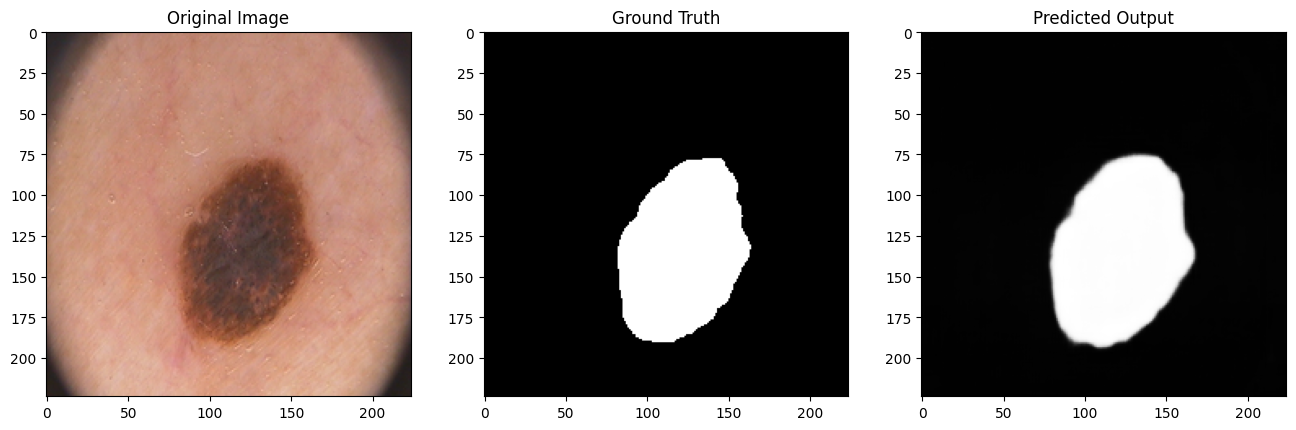

In [53]:
img_num = 49
img_pred = model_1.predict(x_test[img_num].reshape(1,224,224,3))

plt.figure(figsize=(16,16))

plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')

plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')

plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224, 224), plt.cm.binary_r)
plt.title('Predicted Output')

plt.show()

1/1 [==============================] - 0s 25ms/step


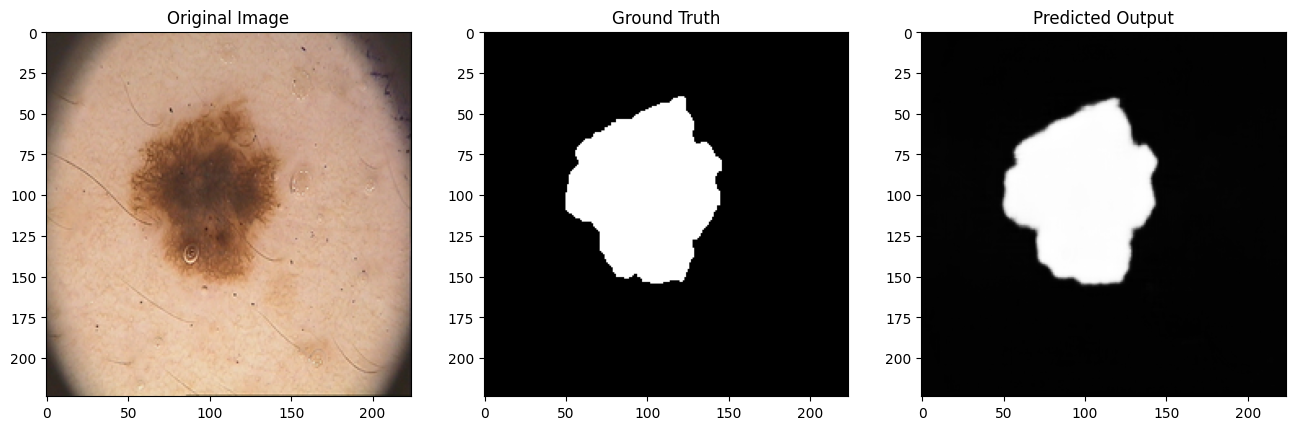

In [54]:
img_num = 10
img_pred = model_1.predict(x_test[img_num].reshape(1,224,224,3))

plt.figure(figsize=(16,16))

plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')

plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')

plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224,224), plt.cm.binary_r)
plt.title('Predicted Output')

plt.show()

1/1 [==============================] - 0s 25ms/step


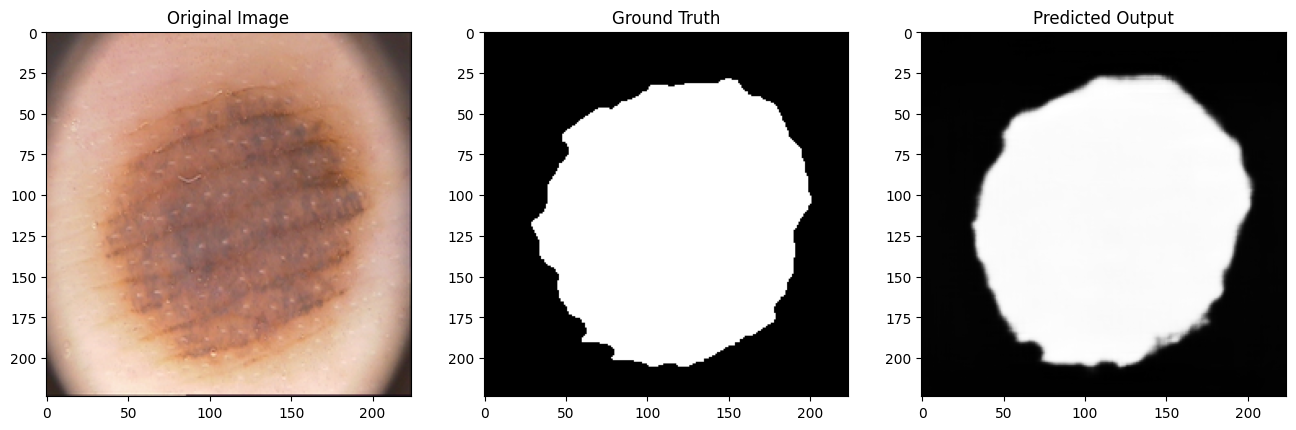

In [55]:
img_num = 36
img_pred = model_1.predict(x_test[img_num].reshape(1,224,224,3))

plt.figure(figsize=(16,16))

plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')

plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')

plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224,224), plt.cm.binary_r)
plt.title('Predicted Output')

plt.show()

1/1 [==============================] - 0s 24ms/step


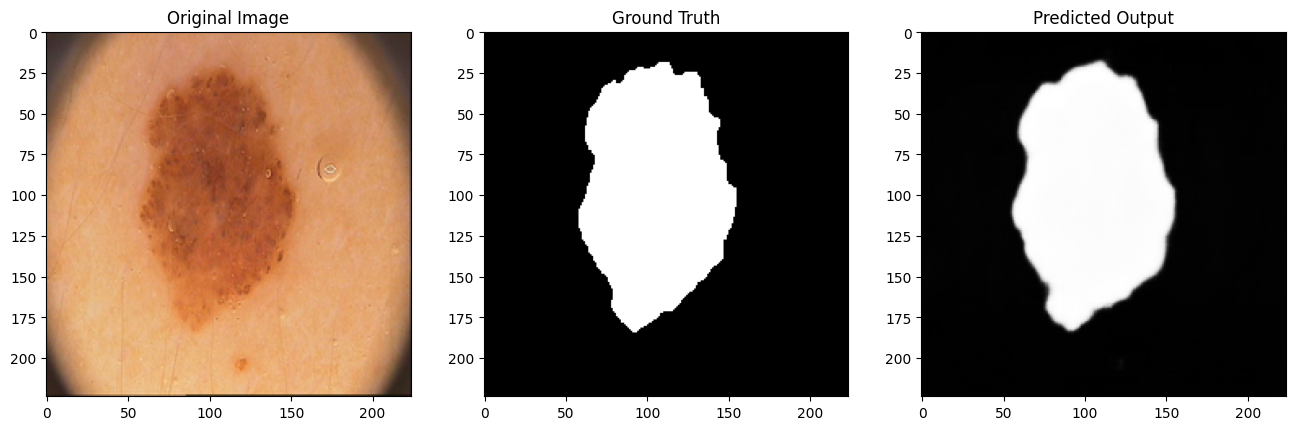

In [56]:
img_num = 32
img_pred = model_1.predict(x_test[img_num].reshape(1,224,224,3))

plt.figure(figsize=(16,16))

plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')

plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')

plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224,224), plt.cm.binary_r)
plt.title('Predicted Output')

plt.show()

1/1 [==============================] - 0s 24ms/step


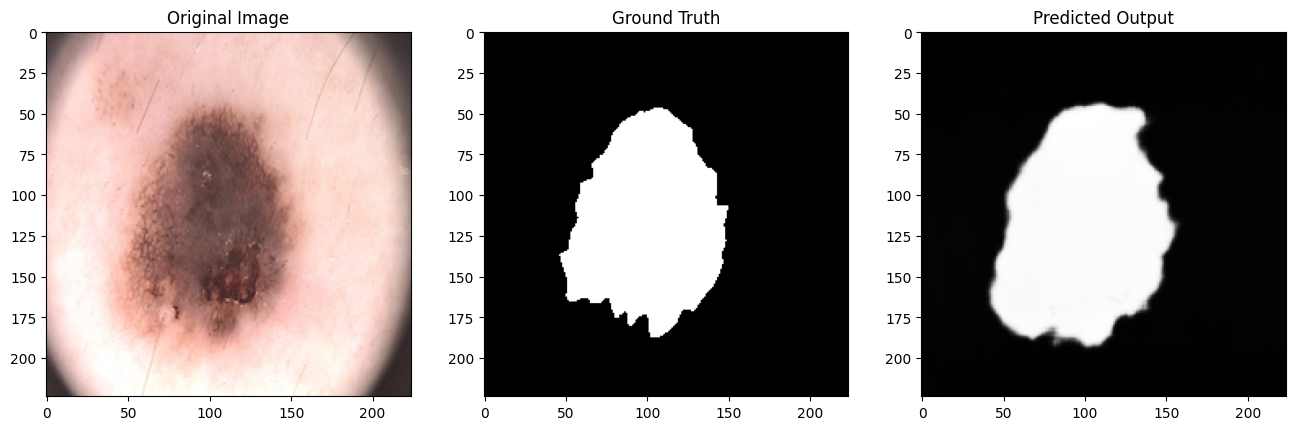

In [57]:
img_num = 29
img_pred = model_1.predict(x_test[img_num].reshape(1,224,224,3))

plt.figure(figsize=(16,16))

plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')

plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')

plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224,224), plt.cm.binary_r)
plt.title('Predicted Output')

plt.show()

1/1 [==============================] - 0s 27ms/step


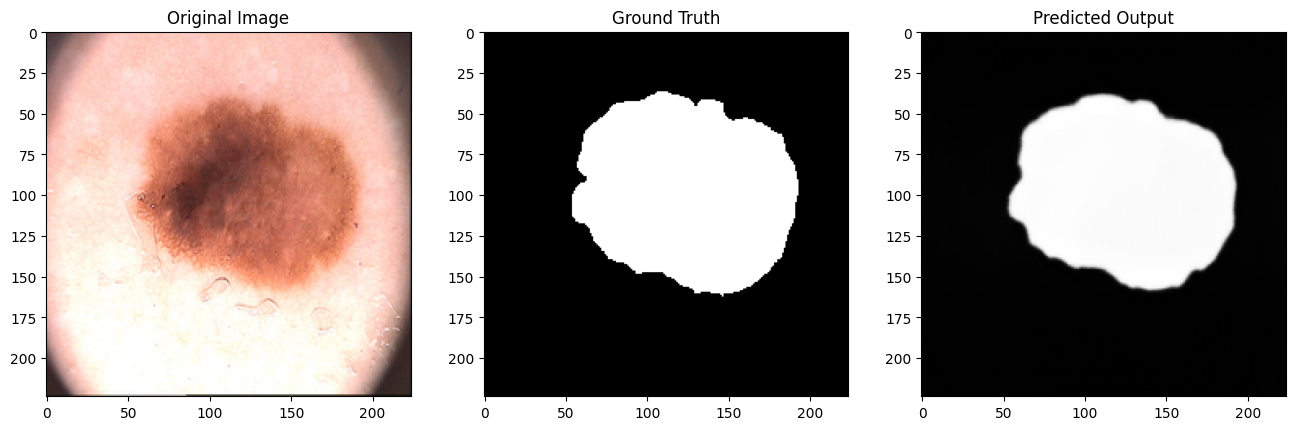

In [58]:
img_num = 21
img_pred = model_1.predict(x_test[img_num].reshape(1,224,224,3))

plt.figure(figsize=(16,16))

plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')

plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')

plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224,224), plt.cm.binary_r)
plt.title('Predicted Output')

plt.show()

## Final Enhance

* Currently the predicted outputs are blurry because the predicted pixel values are in the range 0 - 1.  
* To make clear edge preditions we can enhance our image by rounding up the pixel values to 1 which are > 0.5  .
* While rounding down the pixel values to 0 which are < 0.5.
* We can enhance the image to look for absolute shape predicted by ceiling and flooring the predicted values.

In [59]:
def enhance(img):
    sub = (model_1.predict(img.reshape(1,224,224,3))).flatten()

    for i in range(len(sub)):
        if sub[i] > 0.5:
            sub[i] = 1
        else:
            sub[i] = 0
            
    return sub

In [60]:
plt.figure(figsize=(12,12))

plt.suptitle('Comparing the Prediction after enhancement')

plt.subplot(3,2,1)
plt.imshow(y_test[21],plt.cm.binary_r)
plt.title('Ground Truth')

plt.subplot(3,2,2)
plt.imshow(enhance(x_test[21]).reshape(224,224), plt.cm.binary_r)
plt.title('Predicted')

plt.subplot(3,2,3)
plt.imshow(y_test[47],plt.cm.binary_r)
plt.title('Ground Truth')

plt.subplot(3,2,4)
plt.imshow(enhance(x_test[47]).reshape(224,224), plt.cm.binary_r)
plt.title('Predicted')

plt.subplot(3,2,5)
plt.imshow(y_test[36],plt.cm.binary_r)
plt.title('Ground Truth')

plt.subplot(3,2,6)
plt.imshow(enhance(x_test[36]).reshape(224,224), plt.cm.binary_r)
plt.title('Predicted')

plt.show()

1/1 [==============================] - 0s 25ms/step
